Taylor Manivanh

8/27/2022

Music Recommender
<a id='index'></a>

# Spotify Music Recommender
Analyze Spotify Music data for details on genre, tempo, popularity, etc. to determine trends between songs and recommend a playlist of similar songs.

## Index:
### [0. Import Statements](#import)
### [1. Music Data](#data)
### [2. Exploratory Data Analysis](#explore)
### [3. Recommendation Engine](#rec)

<a id='import'></a>
## 0. Import Statements

In [1]:
# Data transformation
import os
import spotipy
import pandas as pd
import numpy as np
import datetime as dt
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from yellowbrick.target import FeatureCorrelation
# Recommendation Packages
from collections import defaultdict
from scipy.spatial.distance import cdist
import difflib
# Spotipy credentials to search for external songs in the Spotify catalogue
from spotipy.oauth2 import SpotifyClientCredentials
import difflib
%matplotlib inline

<a id='data'></a>
## 1. Music Data
Spotify data sourced from [Kaggle](https://www.kaggle.com/datasets/vatsalmavani/spotify-dataset?resource=download)

Initial view of datasets and columns included in each.
Datasets:

    a. data
    b. data_by_artists
    c. data_by_genre
    d. data_by_year
    e. data_w_genres

[Index](#index)

In [2]:
data = pd.read_csv('data.csv')
data_by_artists = pd.read_csv('data_by_artist.csv')
data_by_genres = pd.read_csv('data_by_genres.csv')
data_by_year = pd.read_csv('data_by_year.csv')
data_w_genres = pd.read_csv('data_w_genres.csv')

In [4]:
data.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
0,0.0594,1921,0.982,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878000,10,0.665,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954
1,0.9630,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,7,0.160,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936
2,0.0394,1921,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,3,0.101,-14.850,1,Gati Bali,5,1921,0.0339,110.339
3,0.1650,1921,0.967,['Frank Parker'],0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,5,0.381,-9.316,1,Danny Boy,3,1921,0.0354,100.109
4,0.2530,1921,0.957,['Phil Regan'],0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,3,0.229,-10.096,1,When Irish Eyes Are Smiling,2,1921,0.0380,101.665


In [5]:
data_by_artists.head()

,mode,count,acousticness,artists,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key
0,1,9,0.590111,"""Cats"" 1981 Original London Cast",0.467222,250318.555556,0.394003,0.011400,0.290833,-14.448000,0.210389,117.518111,0.389500,38.333333,5
1,1,26,0.862538,"""Cats"" 1983 Broadway Cast",0.441731,287280.000000,0.406808,0.081158,0.315215,-10.690000,0.176212,103.044154,0.268865,30.576923,5
2,1,7,0.856571,"""Fiddler On The Roof” Motion Picture Chorus",0.348286,328920.000000,0.286571,0.024593,0.325786,-15.230714,0.118514,77.375857,0.354857,34.857143,0
3,1,27,0.884926,"""Fiddler On The Roof” Motion Picture Orchestra",0.425074,262890.962963,0.245770,0.073587,0.275481,-15.639370,0.123200,88.667630,0.372030,34.851852,0
4,1,7,0.510714,"""Joseph And The Amazing Technicolor Dreamcoat""...",0.467143,270436.142857,0.488286,0.009400,0.195000,-10.236714,0.098543,122.835857,0.482286,43.000000,5


In [6]:
data_by_genres.head()

,mode,genres,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key
0,1,21st century classical,0.979333,0.162883,1.602977e+05,0.071317,0.606834,0.361600,-31.514333,0.040567,75.336500,0.103783,27.833333,6
1,1,432hz,0.494780,0.299333,1.048887e+06,0.450678,0.477762,0.131000,-16.854000,0.076817,120.285667,0.221750,52.500000,5
2,1,8-bit,0.762000,0.712000,1.151770e+05,0.818000,0.876000,0.126000,-9.180000,0.047000,133.444000,0.975000,48.000000,7
3,1,[],0.651417,0.529093,2.328809e+05,0.419146,0.205309,0.218696,-12.288965,0.107872,112.857352,0.513604,20.859882,7
4,1,a cappella,0.676557,0.538961,1.906285e+05,0.316434,0.003003,0.172254,-12.479387,0.082851,112.110362,0.448249,45.820071,7


In [7]:
data_by_year.head()

,mode,year,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key
0,1,1921,0.886896,0.418597,260537.166667,0.231815,0.344878,0.205710,-17.048667,0.073662,101.531493,0.379327,0.653333,2
1,1,1922,0.938592,0.482042,165469.746479,0.237815,0.434195,0.240720,-19.275282,0.116655,100.884521,0.535549,0.140845,10
2,1,1923,0.957247,0.577341,177942.362162,0.262406,0.371733,0.227462,-14.129211,0.093949,114.010730,0.625492,5.389189,0
3,1,1924,0.940200,0.549894,191046.707627,0.344347,0.581701,0.235219,-14.231343,0.092089,120.689572,0.663725,0.661017,10
4,1,1925,0.962607,0.573863,184986.924460,0.278594,0.418297,0.237668,-14.146414,0.111918,115.521921,0.621929,2.604317,5


In [8]:
data_w_genres.head()

,genres,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count
0,['show tunes'],"""Cats"" 1981 Original London Cast",0.590111,0.467222,250318.555556,0.394003,0.011400,0.290833,-14.448000,0.210389,117.518111,0.389500,38.333333,5,1,9
1,[],"""Cats"" 1983 Broadway Cast",0.862538,0.441731,287280.000000,0.406808,0.081158,0.315215,-10.690000,0.176212,103.044154,0.268865,30.576923,5,1,26
2,[],"""Fiddler On The Roof” Motion Picture Chorus",0.856571,0.348286,328920.000000,0.286571,0.024593,0.325786,-15.230714,0.118514,77.375857,0.354857,34.857143,0,1,7
3,[],"""Fiddler On The Roof” Motion Picture Orchestra",0.884926,0.425074,262890.962963,0.245770,0.073587,0.275481,-15.639370,0.123200,88.667630,0.372030,34.851852,0,1,27
4,[],"""Joseph And The Amazing Technicolor Dreamcoat""...",0.510714,0.467143,270436.142857,0.488286,0.009400,0.195000,-10.236714,0.098543,122.835857,0.482286,43.000000,5,1,7


## Clean the Spotify song dataset

In [19]:
# Remove the '[]' and quotations from the artists column
data['artists'] = data['artists'].map(lambda x: x.lstrip("['").rstrip("']")).map(lambda x: x.replace("'",""))
data.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
0,0.0594,1921,0.982,"Sergei Rachmaninoff, James Levine, Berliner Ph...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878000,10,0.665,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954
1,0.9630,1921,0.732,Dennis Day,0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,7,0.160,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936
2,0.0394,1921,0.961,KHP Kridhamardawa Karaton Ngayogyakarta Hadini...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,3,0.101,-14.850,1,Gati Bali,5,1921,0.0339,110.339
3,0.1650,1921,0.967,Frank Parker,0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,5,0.381,-9.316,1,Danny Boy,3,1921,0.0354,100.109
4,0.2530,1921,0.957,Phil Regan,0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,3,0.229,-10.096,1,When Irish Eyes Are Smiling,2,1921,0.0380,101.665


<a id='explore'></a>
## 2. Exploratory Data Analysis

Deep dive into datasets and creation of visualizations for a better understanding of data trends.

### [2a. Summary statistics for columns](#2a)
### [2b. Top songs and artists by popularity](#2b)
### [2c. Songs per year](#2c)
### [2d. Genre breakdown for song metrics](#2d)
### [2e. Clustering songs and genres](#2e)
### [2f. Feature Correlation on popularity](#2f)

[Index](#index)

<a id='2a'></a>
### 2a. Songs Summary Statistics

In [14]:
# Create a function to run summary statistics on numerical columns
def statistics(df, columns):
    df_copy = df.copy()
    for c in columns:
        print(c)
        print(f"Count Nonnull {c}: ", df_copy[c].count())
        print(f"Count Null {c}: ", df_copy[c].isna().sum())
        print(f"Mean {c}: ", np.round(df_copy[c].mean(), 2))
        print(f"Median {c}: ", np.round(df_copy[c].median(), 2))
        print(f"Min {c}: ", np.round(df_copy[c].min(), 2))
        print(f"Max {c}: ", np.round(df_copy[c].max(), 2))
        print(f"Std. Dev {c}: ", np.round(df_copy[c].std(), 2))   
        print("---------------------------------------\n")


In [15]:
data_numeric = data.drop(['artists', 'id','name','release_date'], axis=1) 
statistics(data_numeric, list(data_numeric.columns))

valence
Count Nonnull valence:  170653
Count Null valence:  0
Mean valence:  0.53
Median valence:  0.54
Min valence:  0.0
Max valence:  1.0
Std. Dev valence:  0.26
---------------------------------------

year
Count Nonnull year:  170653
Count Null year:  0
Mean year:  1976.79
Median year:  1977.0
Min year:  1921
Max year:  2020
Std. Dev year:  25.92
---------------------------------------

acousticness
Count Nonnull acousticness:  170653
Count Null acousticness:  0
Mean acousticness:  0.5
Median acousticness:  0.52
Min acousticness:  0.0
Max acousticness:  1.0
Std. Dev acousticness:  0.38
---------------------------------------

danceability
Count Nonnull danceability:  170653
Count Null danceability:  0
Mean danceability:  0.54
Median danceability:  0.55
Min danceability:  0.0
Max danceability:  0.99
Std. Dev danceability:  0.18
---------------------------------------

duration_ms
Count Nonnull duration_ms:  170653
Count Null duration_ms:  0
Mean duration_ms:  230948.31
Median durati

<a id='2b'></a>
### 2b. Top Songs and Artists by Popularity

In [49]:
# Select song titles information 
songs = data[['id','artists', 'name', 'popularity']].copy()
songs['song'] = songs['name'] + ' - ' + songs['artists']
# Sort songs by highest popularity
songs = songs.sort_values(by=['popularity'], ascending=False).head(5)

# Select artist information 
artists = data_by_artists[['artists', 'popularity']].copy()
# Sort artists by highest popularity
artists = artists.sort_values(by=['popularity'], ascending=False).head(5)

In [170]:
songs

,id,artists,name,popularity,song
19611,47EiUVwUp4C9fGccaPuUCS,"Bad Bunny, Jhay Cortez",Dakiti,100,"Dakiti - Bad Bunny, Jhay Cortez"
19606,3tjFYV6RSFtuktYl3ZtYcq,"24kGoldn, iann dior",Mood (feat. iann dior),99,"Mood (feat. iann dior) - 24kGoldn, iann dior"
19618,0t1kP63rueHleOhQkYSXFY,BTS,Dynamite,97,Dynamite - BTS
19608,4Oun2ylbjFKMPTiaSbbCih,"Cardi B, Megan Thee Stallion",WAP (feat. Megan Thee Stallion),96,"WAP (feat. Megan Thee Stallion) - Cardi B, Meg..."
19610,35mvY5S1H3J2QZyna3TFe0,Ariana Grande,positions,96,positions - Ariana Grande


In [53]:
artists

,artists,popularity
20966,Ritt Momney,93.0
14354,Lele Pons,92.0
15070,Los Legendarios,90.0
11764,Jerry Di,89.0
28263,salem ilese,88.0


<a id='2c'></a>
### 2c. Songs per Year
The Spotify data contains songs from 1921 to 2020. 

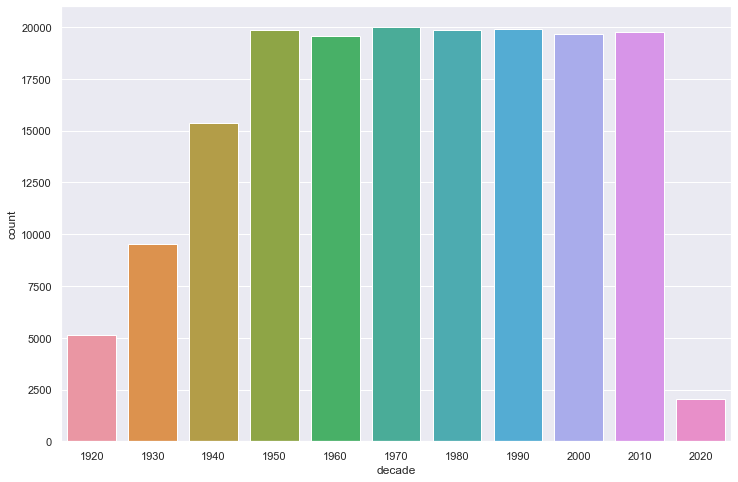

In [153]:
# Create a decade columm that calculates the decade of the year of the song
data['decade'] = data['year'].map(lambda x: int(x/10)* 10)
sns.set(rc={'figure.figsize':(12 ,8)})
b = sns.countplot(x=data['decade'])

Over time, the dataset displayed a steady increase in songs (+ ~50,000 songs) each decade from the 1920s-1950s. With technological advances like vinyl records, tapes, compact disks etc. we can observe the increased accessibility and popularity of the music industry. 

After the 1950s, the data stabilizes and contains ~20,000 songs for the following decades, except for 2020. There is no documentation on when this data was pulled, which could explain why the data for 2020 seems to be incomplete.

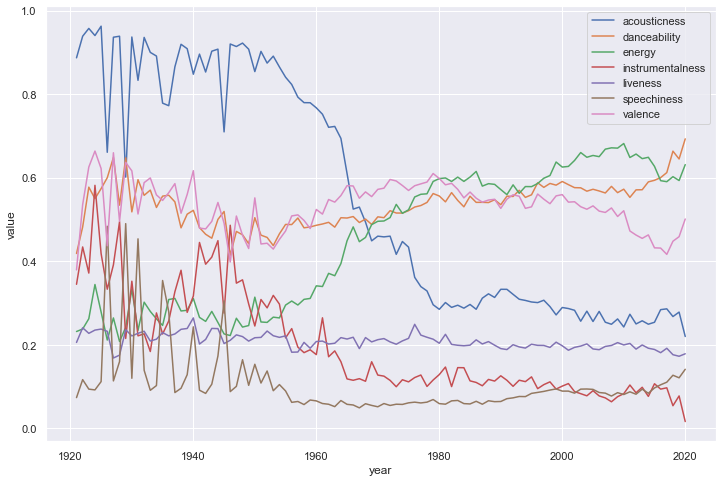

In [154]:
# Create dataset of song metrics
metrics = ['acousticness','danceability', 'energy','instrumentalness','liveness', 'speechiness', 'valence']
year_data = data_by_year[['year', 'acousticness','danceability', 'energy','instrumentalness','liveness', 'speechiness','valence']].copy()
year_data['year'] = pd.to_datetime(year_data['year'], format='%Y').dt.year

# Transform year data into a wide format and plot song metrics over time
sns.set(rc={'figure.figsize':(12 ,8)})
p = sns.lineplot(x='year', y='value', hue='variable', data=pd.melt(year_data, 'year'))
p.legend(loc='upper right')

Diving deeper into each decade of music, we can take a look at the differences in song metrics such as duration, danceability, loudness, etc. 
The plot above shows the shift in the type of music as the decades pass. In 1920s-1950s, songs had higher acousticness and less energy compared to the more recent songs of the 2000s which have an inverse relationship between the two metrics. Songs in the early 1900s often focused on acoustic and instrumental sounds like that of in Jazz or Blues music. Once we enter the 2000s, computers and technology has progressed and as a result we see more upbeat, high energy, and danceable songs become popular.

Text(0.5, 1.0, 'Song Duration')

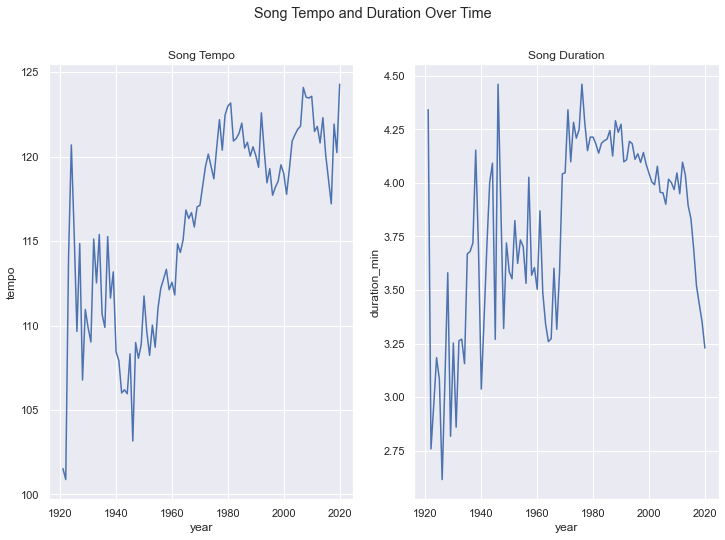

In [169]:
# Create dataset of tempo/duration metrics
metrics = ['tempo', 'duration_ms']
year_data = data_by_year[['year', 'tempo', 'duration_ms']].copy()
year_data['year'] = pd.to_datetime(year_data['year'], format='%Y').dt.year
year_data['duration_min'] = year_data['duration_ms'] / 60000

# Plot tempo and duration over time
fig, axes = plt.subplots(1, 2, figsize=(12,8))
fig.suptitle('Song Tempo and Duration Over Time')

# Tempo plot
sns.lineplot(x='year', y='tempo', data=year_data, ax=axes[0])
axes[0].set_title('Song Tempo')

# Duration plot
sns.lineplot(x='year', y='duration_min', data=year_data, ax=axes[1])
axes[1].set_title('Song Duration')

Similar to the other plots and trends, with the evolution of technology tempo has increased over time as songs being produced with more audio engineering. On the right plot, the duration of songs have fluctuated throughout the early 1900s, but in the 2000s has become more stable with a majority of songs ~4 minutes long. In the most recent years there has been a slight decline in song duration, which can be a result of trends in the music industry such as the rise of streaming platforms. Several factors around streaming payouts may be subtly affecting song lengths of music being released. 

<a id='2d'></a>
### 2d. Genre Breakdown
There are 2,973 genres in the data_by_genres dataset. We can take a look at the top 5 genres in the data and analyze the differences in song metrics.

In [12]:
data_by_genres['genres'].nunique()

2973

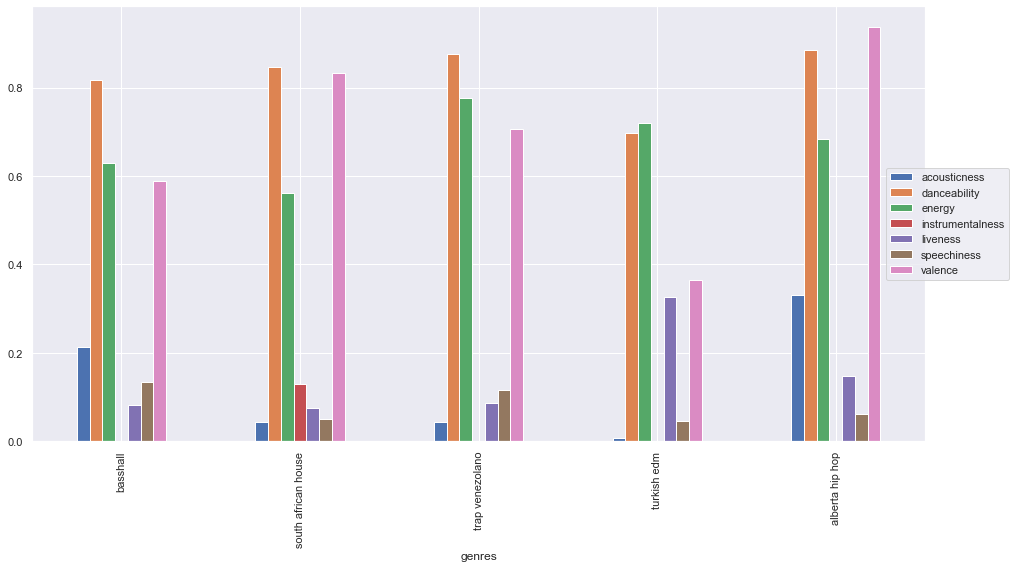

In [53]:
top_5 = data_by_genres.nlargest(5, 'popularity')
metrics = ['acousticness','danceability', 'energy','instrumentalness','liveness', 'speechiness', 'valence']

sns.set(rc={'figure.figsize':(12 ,8)})
top_5.plot(x='genres', y=metrics, kind='bar', figsize=(16, 8))
plt.legend(bbox_to_anchor=(1.1, .5), loc='right')

The top 5 genres in the data all have high values of danceability, energy and valence with values around 0.6. These three metrics show that the most popular genres are those that are upbeat and have positive characteristics (cheery, happy, euphoric, etc.) And with 4 out of the 5 top songs, only South African House has any value for instrumentalness. Hence, the top genres are seen to be more electronically engineered dance music. 

<a id='2e'></a>
### 2e. Clustering Songs and Genres 
Since there are several thousand songs and almost 3000 genres, we can utilize k-means clustering to partition the data into similar groups. 

Before clustering we must perform feature scaling to transform the song metrics to use the same scale. Once features are scaled, we can enter information into the k-means algorithm. 

K-means clustering partitions *n* observations into *k* clusters in which each observation belongs to the cluster with the closest mean.

#### K-Means Algorithm:
        1. Decide number of clusters, k
        2. Randomly assign a centroid to each of the k clusters
        3. Calculate the distance of all oberservations to each of the k centroids 
        4. Assign observations to the closest centroid
        5. Find the new location of the centroid by taking the mean of all the observations in each cluster
        6. Repeat 3-5 until the centroids do not change position

#### Evaluation
**Silhouette Coefficient**: A silhouette coefficient of 0 indicates that clusters are significantly overlapping one another, and a silhouette coefficient of 1 indicates clusters are well-separated.

#### Visualization
Visualization of clusters can be done with PCA and t-SNE.

<ins>**PCA (Principal Component Analysis)**: An unsupervised linear dimensionality reduction and data viz technique for very high dimensional data. High dimensional data is hard to gain insight and is very computationally intensive. 
- Linear dimensionality reduction technique
- Deterministic algorithm
- PCA tries to preserve the Global Structure of data
- Highly affected by outliers
- Works by rotating the vectors for preserving variance


<ins>**t-SNE (t-Distributed Stochastic Neighbourhood Embedding)**: An unsupervised non-linear dimensionality reduction and data viz technique. It embeds the points from a higher dimension to a lower dimension trying to preserve the neighborhood of that point.
- Non-linear dimmensionality reduction technique
- Non-deterministic or randomized algorithm
- t-SNE tries to preserve the local structure (cluster) of data
- Can handle outliers
- Works by minimising the distance between the point in a gaussian

In [37]:
# Song Clusters
# Select numeric song metric features
song_data = data.select_dtypes(np.number)
# Create a pipeline to sequentially transform the data before fitting to K-means
# Generate 20 song clusters
song_pipe = Pipeline([('scaler', StandardScaler())
                     ,('kmeans', KMeans(n_clusters=20, verbose=False))]
                    , verbose=True)
# Fit song data to pipeline
song_pipe.fit(song_data)
# Predict and save the cluster results
song_results = song_pipe.predict(song_data)
data['cluster'] = song_results

# Evaluate performance
preprocessed_data = song_pipe['scaler'].transform(song_data)
predicted_labels = song_pipe['kmeans'].labels_
print('Silhouette Score: ', silhouette_score(preprocessed_data, predicted_labels))

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing kmeans, total=   6.0s
Silhouette Score:  0.1580684082827837


Silhouette Score close to 0 means that the song clusters will have significant overlap. We can plot the clusters to view this overlap.
Since there is more song data, PCA is used to visualize the clusters for efficiency.

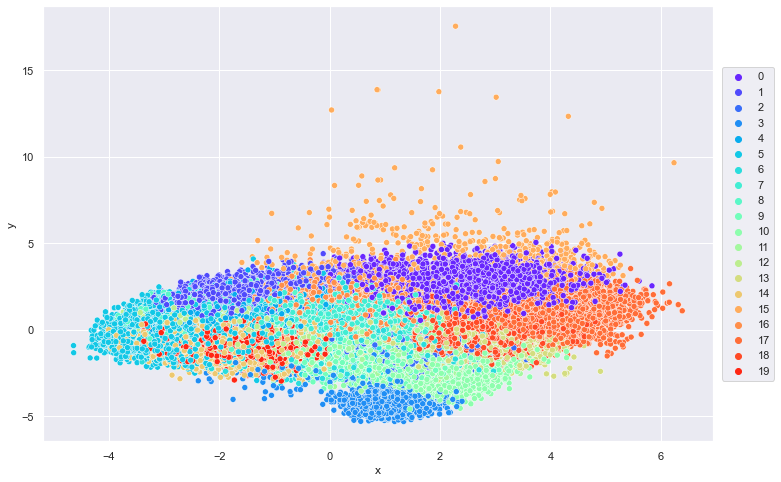

In [60]:
# Create a pipeline to sequentially scale the data and implement PCA for dimensionality reduction
pca_pipe = Pipeline([('scaler', StandardScaler())
                    ,('PCA', PCA(n_components=2))])
song_embed = pca_pipe.fit_transform(song_data)
projection = pd.DataFrame(columns=['x','y'], data=song_embed)
projection['title'] = data['name']
projection['cluster'] = data['cluster']

# Plot the clusters
sns.set(rc={'figure.figsize':(12 ,8)})
palette = sns.color_palette('rainbow', 20)
ax = sns.scatterplot(data=projection, x='x', y='y', hue='cluster', palette=palette, legend='full')
plt.legend(bbox_to_anchor=(1.1, 0.5), loc='right')

In [63]:
# Genre Clusters
# Select numeric song metric features
genre_data = data_by_genres.select_dtypes(np.number)
# Create a pipeline to sequentially transform the data before fitting to K-means
# Generate 10 genre clusters
genre_pipe = Pipeline([('scaler', StandardScaler())
                     ,('kmeans', KMeans(n_clusters=10, verbose=False))]
                    , verbose=True)
# Fit song data to pipeline
genre_pipe.fit_transform(genre_data)
# Predict and save the cluster results
genre_results = genre_pipe.predict(genre_data)
data_by_genres['cluster'] = genre_results

# Evaluate performance
preprocessed_data = genre_pipe['scaler'].transform(genre_data)
predicted_labels = genre_pipe['kmeans'].labels_
print('Silhouette Score: ', silhouette_score(preprocessed_data, predicted_labels))

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing kmeans, total=   0.1s
Silhouette Score:  0.1352323152345467


Silhouette Score close to 0 means that the song clusters will have significant overlap. We can plot the clusters to view this overlap.
There are multiple song metricws that make it difficult to visualize the clusters in a high dimensional space so we use t-SNE to compress the data.

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2973 samples in 0.005s...
[t-SNE] Computed neighbors for 2973 samples in 0.180s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2973
[t-SNE] Computed conditional probabilities for sample 2000 / 2973
[t-SNE] Computed conditional probabilities for sample 2973 / 2973
[t-SNE] Mean sigma: 0.777516
[t-SNE] Computed conditional probabilities in 0.055s
[t-SNE] Iteration 50: error = 81.8501892, gradient norm = 0.0244271 (50 iterations in 0.328s)
[t-SNE] Iteration 100: error = 76.3593826, gradient norm = 0.0032615 (50 iterations in 0.310s)
[t-SNE] Iteration 150: error = 76.1690521, gradient norm = 0.0010803 (50 iterations in 0.283s)
[t-SNE] Iteration 200: error = 76.1254654, gradient norm = 0.0006117 (50 iterations in 0.270s)
[t-SNE] Iteration 250: error = 76.1114044, gradient norm = 0.0009909 (50 iterations in 0.280s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.111404
[t-SNE] Iteration 300: erro

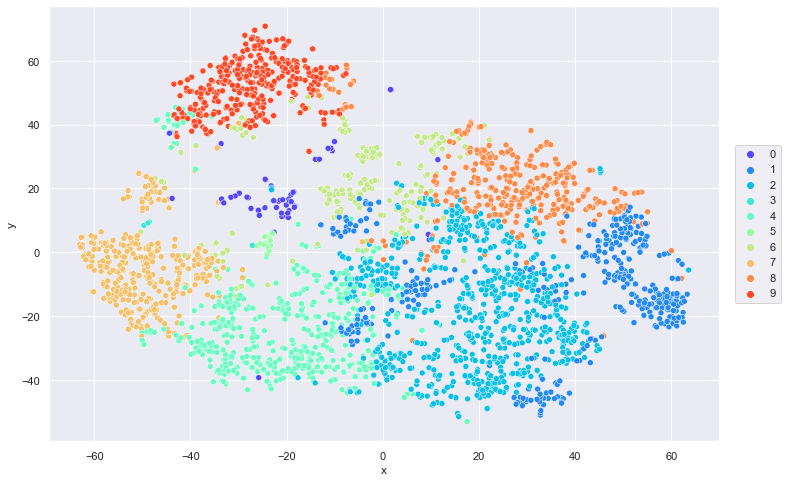

In [65]:
# Create a pipeline to sequentially scale the data and implement t-SNE for dimensionality reduction
tsne_pipe = Pipeline([('scaler', StandardScaler())
                    ,('tsne', TSNE(n_components=2, verbose=2))])
genre_embed = tsne_pipe.fit_transform(genre_data)
projection = pd.DataFrame(columns=['x','y'], data=genre_embed)
projection['title'] = data_by_genres['genres']
projection['cluster'] = data_by_genres['cluster']

# Plot the clusters
sns.set(rc={'figure.figsize':(12 ,8)})
palette = sns.color_palette('rainbow', 10)
ax = sns.scatterplot(data=projection, x='x', y='y', hue='cluster', palette=palette, legend='full')
plt.legend(bbox_to_anchor=(1.1, 0.5), loc='right')

<a id='2f'></a>
### 2f. Feature Correlation on Popularity 

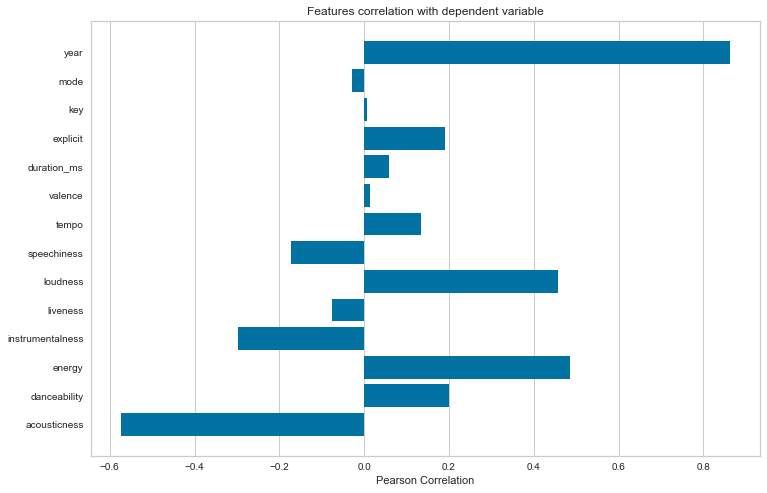

<AxesSubplot:title={'center':'Features correlation with dependent variable'}, xlabel='Pearson Correlation'>

In [5]:
metrics = ['acousticness','danceability','energy','instrumentalness','liveness','loudness',
           'speechiness','tempo','valence','duration_ms','explicit','key','mode','year']
x = data[metrics]
y = data['popularity']

features = np.array(metrics)
visualizer = FeatureCorrelation(labels=features)

plt.rcParams['figure.figsize']=(12,8)
visualizer.fit(x,y)
visualizer.show()

The above plot demonstrates the correlation of each of the metrics in the song dataset to the popularity variable. Year, loudness and energy are highly correlated to the popularity of a song while feature like tempo, liveliness and acousticness do not have a strong impact.

<a id='rec'></a>
## 3. Recommendation Engine

The EDA revealed that songs and genres with similar metrics are clustered together. With this information a recommendation engine can be built to create a playlist of similar songs that is based on an songs previously listened by the user.

**Content-Based Filtering**: Based on the principle that if you like a particular item, you will also like this other item. To make recommendations, the algorithm uses a profile of the customer's preferences (listened songs) and a description of an item (tempo, liveliness, energy, etc) to work out the similarity of items using cosine and Euclidean distances. 

### [3a. Pulling External Songs](#3a)
### [3b. Creating Song Recommendations](#3b)

[Index](#index)

<a id='3a'></a>
### 3a. Pulling External Songs

The current song data only contains information on some songs from 1921-2020, so we need to pull song data and metrics for songs outside of the data using the Spotipy library. The *search* function allows us to query external Spotify data to bring in additional songs that were not included in the original dataset.

Spotify Credentials require a [Spotify for Developers](https://developer.spotify.com/documentation/general/guides/authorization/app-settings/) account. 

In [38]:
def search_song(name, year, artist=False):
    """
    Searches a song in Spotify's catalogue by input name and year by default. If the artist name is known and is a single artist, 
    then it can be specified for a specific song. (For cases when the multiple songs have the same name in the same year)
    Parameters:
        name (str): String of song name
        year (str): String of song year
        artist (str): Optional argument is single artist name is known
    Returns:
        song_info (df): DataFrame of song and song metrics 
    """
    # spotipy credentials
    sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=os.environ.get("SPOTIPY_CLIENT_ID"),
                                                           client_secret=os.environ.get("SPOTIPY_CLIENT_SECRET")))
    song_info = defaultdict()
    # Query the Spotify catalogue with the song name and year. Select the first match
    if artist:
        results = sp.search(q=f'track: {name}, artist: {artist}, year: {year}', limit=1)
    else:
        results = sp.search(q=f'track: {name}, year: {year}', limit=1)
    
    # If no results, the data is not in the Spotify catalogue
    if results['tracks']['items'] == []:
        return None
    
    # Get the id of the first match and select the corresponing song metrics
    results = results['tracks']['items'][0]
    
    song_id = results['id']
    metrics = sp.audio_features(song_id)[0]
    
    # Save song details
    artists = ''
    for i in results['artists']:
        if artists == '':
            artists = i['name']
        else:
            artists = artists + ', ' + i['name']
    song_info['artists'] = [artists]
    song_info['name'] = [name]
    #song_info['artists'] = [artist]
    song_info['year'] = [year]
    song_info['explicit'] = [int(results['explicit'])]
    song_info['duration_ms'] = [results['duration_ms']]
    song_info['popularity'] = [results['popularity']]
    
    # Save numeric song metrics
    for k, v in metrics.items():
        song_info[k] = v
    
    return pd.DataFrame(song_info)

In [39]:
x = search_song('Piano Concerto No. 3 in D Minor, Op. 30: III. Finale. Alla breve','1921')
x

,artists,name,year,explicit,duration_ms,popularity,danceability,energy,key,loudness,...,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,time_signature
0,"Sergei Rachmaninoff, James Levine, Berliner Ph...","Piano Concerto No. 3 in D Minor, Op. 30: III. ...",1921,0,831667,3,0.279,0.211,10,-20.096,...,0.878,0.665,0.0594,80.954,audio_features,4BJqT0PrAfrxzMOxytFOIz,spotify:track:4BJqT0PrAfrxzMOxytFOIz,https://api.spotify.com/v1/tracks/4BJqT0PrAfrx...,https://api.spotify.com/v1/audio-analysis/4BJq...,4


In [40]:
x = search_song('Honey','2021')
x

,artists,name,year,explicit,duration_ms,popularity,danceability,energy,key,loudness,...,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,time_signature
0,Mad Tsai,Honey,2021,1,170328,58,0.376,0.524,6,-7.004,...,0,0.105,0.439,160.378,audio_features,58QZNN5P9UC8moU8mWVzNy,spotify:track:58QZNN5P9UC8moU8mWVzNy,https://api.spotify.com/v1/tracks/58QZNN5P9UC8...,https://api.spotify.com/v1/audio-analysis/58QZ...,4


In [41]:
x = search_song('Honey','2021','Halsey')
x

,artists,name,year,explicit,duration_ms,popularity,danceability,energy,key,loudness,...,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,time_signature
0,Halsey,Honey,2021,1,173840,59,0.471,0.857,9,-5.069,...,0.000054,0.0682,0.393,160.069,audio_features,7p58AJeuaFSUHTnPe5NFaf,spotify:track:7p58AJeuaFSUHTnPe5NFaf,https://api.spotify.com/v1/tracks/7p58AJeuaFSU...,https://api.spotify.com/v1/audio-analysis/7p58...,4


<a id='3b'></a>
### 3b. Creating Song Recommendations

A content based filtering algorithm will be used to create the song recommendation. 
1. For each song in an inputted playlist, we need to calculate the average vector of the song metrics.
2. Find the n-closest data points in the Spotify data to the average vector. Make sure to exclude the 
    songs included in the input data.
3. Recommend the top songs that match to the top n data points. 

The cosine distance formula is used to determine the "n-closest" data points. If two songs have vectors that are parallel, the angle between them are zero, thus, the cosine distance will be 0.

The [cdist](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html) function in SciPy computes the distance between *m* points using different distance metrics (Euclidean, jaccard, cosine, etc.). 

In [80]:
# 1. To calculate avg vector for song metrics we neeed to find the song and its corresponding metrics
def get_data(song, sp_data):
    """
    Gets data needed to from Spotify song data. If the data doesn't include the song, 
    use the search_song function to get data from the Spotify catalogue.
    Parameters:
        song (dict): Dictionary with key-value pairs for song name, artist, and release year
        sp_data (dataframe): Dataframe of the Spotify data from the .csv file
    Returns:
        song_info (df): DataFrame of song and song metrics 
    """
    
    # Check if song is present in Spotify dataframe
    try:
        # Select the row where the conditions are met
        if 'artists' in song.keys():
            song_data = sp_data[(sp_data['name'] == song['name']) &
                              (sp_data['year'] == song['year']) &
                              (sp_data['artists'] == song['artists'])].iloc[0]
        else:
            song_data = sp_data[(sp_data['name'] == song['name']) &
                              (sp_data['year'] == song['year'])].iloc[0]
        return song_data
                          
    except IndexError:
        return search_song(song['name'], song['year'])
         
        
# 2. Calculate the average vector distance of the song metrics
def avg_vector(song_list, sp_data):
    """
    Calculated the average vector of a list of inputted songs.
    Parameters:
        song_list(dict): Dictionary with key-value pairs for song name, artist, and release year
        sp_data (dataframe): Dataframe of the Spotify data from the .csv file
    Returns:
        song_info (df): DataFrame of song and song metrics 
    """
    
    metrics = ['valence', 'year', 'acousticness', 'danceability', 'duration_ms',
       'energy', 'explicit', 'instrumentalness', 'key', 'liveness', 'loudness',
       'mode', 'popularity', 'speechiness', 'tempo']
    
    vectors = []
    for song in song_list:
        song_data = get_data(song, sp_data)
        # If song is not in the dataframe or the catalogue, print a message
        if song_data is None:
            song_name = song['name']
            print(f'Warning {song_name} does not exist in Spotify or the database')
        # Add the song's vector to the list of vectors
        song_vec = song_data[metrics].values
        vectors.append(song_vec)
        
    # Create a matrix of the song vectors and take the average
    matrix = np.array(list(vectors), dtype=object)
    return np.mean(matrix, axis=0)


def flatten_dict(dict_list):
    """
    Flatten nested dictionaries into a dictionary of lists
    Parameters:
        dict_list(dict): Dictionary of dictionaries that contain name, year and artist (if speficied) of a song
    Returns:
        flat_dict(dict): Dictionary of key-value pairs with song name and list of values.
    """
    
    flat_dict = defaultdict()
    # Each dedupe nested dictionaries
    for key in dict_list[0].keys():
        flat_dict[key] = []
    for d in dict_list:
        for k, v in d.items():
            flat_dict[k].append(v)
    return flat_dict


# 3. Recommend top songs based on input list and K-means clustering
def recommender(song_list, sp_data, n_songs=15):
    """
    Recommend a default of 15 songs based on an inputted list of songs.
    Parameters:
        song (dict): Dictionary with key-value pairs for song name, artist, and release year
        sp_data (dataframe): Dataframe of the Spotify data from the .csv file
        n_songs(int): Number of recommendated songs to be output. Default set to 15
    Returns:
        rec_songs(dict): Dictionary of recommended songs with name, year and artists
    """    
    
    metrics = ['valence', 'year', 'acousticness', 'danceability', 'duration_ms',
       'energy', 'explicit', 'instrumentalness', 'key', 'liveness', 'loudness',
       'mode', 'popularity', 'speechiness', 'tempo']
    
    final_cols = ['name', 'artists', 'year']
    song_dict = flatten_dict(song_list)
    
    # Identify the avg vector of the song list and set data point of the center
    song_center = avg_vector(song_list, sp_data)
    
    # Create a pipeline for scaling features and running k-means algorithm on numerical data from the Spotify dataset
    pipe = Pipeline([('scaler', StandardScaler()),
                     ('kmeans', KMeans(n_clusters=20, verbose=0))]
                    , verbose=False)
    x = sp_data.select_dtypes(np.number)
    pipe.fit(x)

    scaled_data = pipe.transform(sp_data[metrics])
    scaled_center = pipe.transform(song_center.reshape(1,-1))

    
    # Calculate the distances between the scaled Spotify data and the scaled center of the song list
    dists = cdist(scaled_center, scaled_data, 'cosine')
    # Index and sort the distances 
    index = list(np.argsort(dists)[:, :n_songs,][0])
    
    # Find recommended songs from the Spotify dataset
    rec_songs = sp_data.iloc[index]
    # Make sure recommended songs do not include songs from the inputted list of songs
    rec_songs = rec_songs[~rec_songs['name'].isin(song_dict['name'])]
    
    # Return recommended songs in a list of dictionaries format
    return rec_songs[final_cols].to_dict(orient='records')

In [81]:
test = [{'name': 'Come As You Are', 'year':1991},
                {'name': 'Smells Like Teen Spirit', 'year': 1991},
                {'name': 'Lithium', 'year': 1992},
                {'name': 'All Apologies', 'year': 1993},
                {'name': 'Stay Away', 'year': 1993}]

In [82]:
x = recommender(test, data)
x

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


[{'name': 'Of Wolf And Man', 'artists': "['Metallica']", 'year': 1991},
 {'name': 'Just Us Kids', 'artists': "['James McMurtry']", 'year': 2008},
 {'name': 'In My Dreams', 'artists': "['Dokken']", 'year': 1985},
 {'name': 'Another Try', 'artists': "['Cody Johnson']", 'year': 2009},
 {'name': 'Bleeders', 'artists': "['The Wallflowers']", 'year': 1996},
 {'name': 'Cool World - Digitally Remastered',
  'artists': "['Mondo Rock']",
  'year': 1981},
 {'name': 'Mi Enemigo El Amor', 'artists': "['Pancho Barraza']", 'year': 1998},
 {'name': 'Unholy', 'artists': "['KISS']", 'year': 1992},
 {'name': 'Here For A Good Time',
  'artists': "['George Strait']",
  'year': 2011},
 {'name': 'El Vals del Obrero', 'artists': "['Ska-P']", 'year': 1997},
 {'name': 'Save Up All Your Tears', 'artists': "['Cher']", 'year': 1991},
 {'name': 'Across the Nation',
  'artists': "['The Union Underground']",
  'year': 2002},
 {'name': 'Cuéntame Tu Vida', 'artists': "['Caifanes']", 'year': 1988},
 {'name': 'Amame', 'a

In [12]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('kmeans', KMeans(n_clusters=20, verbose=2))]
                , verbose=False)
scaler = pipe.steps[0][1]
scaler

StandardScaler()

In [14]:
x = np.arange(20)
print(x)
print()
x.reshape(1, -1)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]



array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19]])

In [50]:
x = data.select_dtypes(np.number)

x.columns


Index(['valence', 'year', 'acousticness', 'danceability', 'duration_ms',
       'energy', 'explicit', 'instrumentalness', 'key', 'liveness', 'loudness',
       'mode', 'popularity', 'speechiness', 'tempo'],
      dtype='object')